## 執行以下各段
shift + Enter

In [27]:
import os
import pandas as pd
import numpy as np
from tqdm import tqdm_notebook as tqdm
from my_parser import complete_patterns, missing_patterns, keep_score_sheet_only
import pdftotext
import jieba
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.cluster.hierarchy import ward, dendrogram
import matplotlib.pyplot as plt
from sklearn.cluster import AgglomerativeClustering
from shutil import copyfile
import re

In [2]:
upper_most = 'CAAC審查資料PDF'
all_pdf_files = [ f'{upper_most}/{i}/{j}/{j}.pdf' for i in os.listdir(upper_most) for j in os.listdir(upper_most+'/'+i) ]

In [3]:
DD = []
Failed_files = []
Skipped_files = []
Ocr_files = []

for f in tqdm(all_pdf_files):
    R = complete_patterns(f)
    if type(R) == list:
        if len(R) != 20:
            print('Something wrong!')
            print(R)
            Skipped_files.append(f)
            continue
            
        DD.append(R)
        
    elif R == 'skipped':
        Skipped_files.append(f)
    elif R == 'Ocr required':
        Ocr_files.append(f)
    else:
        Failed_files.append(f)
else:
    print('Done!')

print('*****************************')
print(f'Success: {len(DD)}/{len(all_pdf_files)}')
print(f'Skipped: {len(Skipped_files)}/{len(all_pdf_files)}')
print(f'Ocr required: {len(Ocr_files)}/{len(all_pdf_files)}')
print(f'Failed: {len(Failed_files)}/{len(all_pdf_files)}')


Done!
*****************************
Success: 388/704
Skipped: 261/704
Ocr required: 33/704
Failed: 22/704


In [4]:
missing_DD = []
for f in tqdm(Skipped_files):
    R = missing_patterns(f)
    if R:
        if len(R) != 20:
            print('Something wrong!')
            print(R)
            Failed_files.append(f)
            continue
        missing_DD.append(R)

    else:
        Failed_files.append(f)
else:
    print('Done!')

print('****************************************')
print(f'Success: {len(missing_DD)}/{len(Skipped_files)}')
print(f'Failed: {len(Skipped_files)-len(missing_DD)}/{len(Skipped_files)}')


Done!
****************************************
Success: 213/261
Failed: 48/261


In [30]:
columns = ['系所代碼','準考號碼','姓名','學校',
           '一上班排','一下班排','二上班排','二下班排','三上班排',
           '一上組排','一下組排','二上組排','二下組排','三上組排',
           '一上校排','一下校排','二上校排','二下校排','三上校排',
           'ParserPattern']
df = pd.DataFrame(DD+missing_DD,columns=columns)
df_min = pd.concat([df.iloc[:,i*5+4:i*5+9].min(axis=1) for i in range(3)],axis=1)
df_min.columns=['最佳班排','最佳組排','最佳校排']
pd.concat([df,df_min],axis=1).to_excel('all_is_well2.xlsx',index=False)

# run ocr

In [ ]:
os.mkdir('ocr')
os.mkdir('ocr/original')
os.mkdir('ocr/processed')

In [17]:
# keep scores sheet only to increase ocr processing speed
for f in Ocr_files:
    o = 'ocr/original/'+f.split('/')[1]+'_'+f.split('/')[2]+'.pdf'
    keep_score_sheet_only(f,o)

In [ ]:
# create shell scripts
with open("ocr_scripts.sh","w") as f:
    for file in os.listdir('ocr/original/'):
        i = 'ocr/original/'+file
        o = 'ocr/processed/'+file
        f.write(f"ocrmypdf -l chi_tra {i} {o} --force-ocr\n")

In [ ]:
!sh ocr_scripts.sh

## run file organization

In [56]:
# let me handle it! if found:
from difflib import SequenceMatcher

def similar(a, b):
    return SequenceMatcher(None, a, b).ratio()

ppfiles = ['ocr/processed/'+i for i in os.listdir('ocr/processed/')]
manual_files = Failed_files+ppfiles
FF = []
for file in manual_files:
    with open(file, "rb") as f:
        pdf = pdftotext.PDF(f)
    if 'ocr' in file:
        score_sheet = pdf[0]
    else:
        score_sheet = pdf[2]
    
    FF += [score_sheet[0:400]]

worthy = False
JJ = []
for i, F1 in enumerate(FF):
    A = 0
    for F2 in FF:
        if similar(F1,F2) >= 0.7:
            A += 1
    if A >= 15:
        print('worthy')
        JJ.append(manual_files[i])

if worthy:
    [manual_file.remove(i) for i in JJ]
    
FF = []

In [50]:
# prepare date to run cluster
SS = []
ppfiles = ['ocr/processed/'+i for i in os.listdir('ocr/processed/')]
manual_files = Failed_files+ppfiles
for file in manual_files:
    with open(file, "rb") as f:
        pdf = pdftotext.PDF(f)
    if 'ocr' in file:
        score_sheet = pdf[0]
    else:
        score_sheet = pdf[2]
        
    SS.append(" ".join(jieba.cut(re.sub('\W|\d|[a-zA-Z]','',score_sheet),cut_all=False)))
    

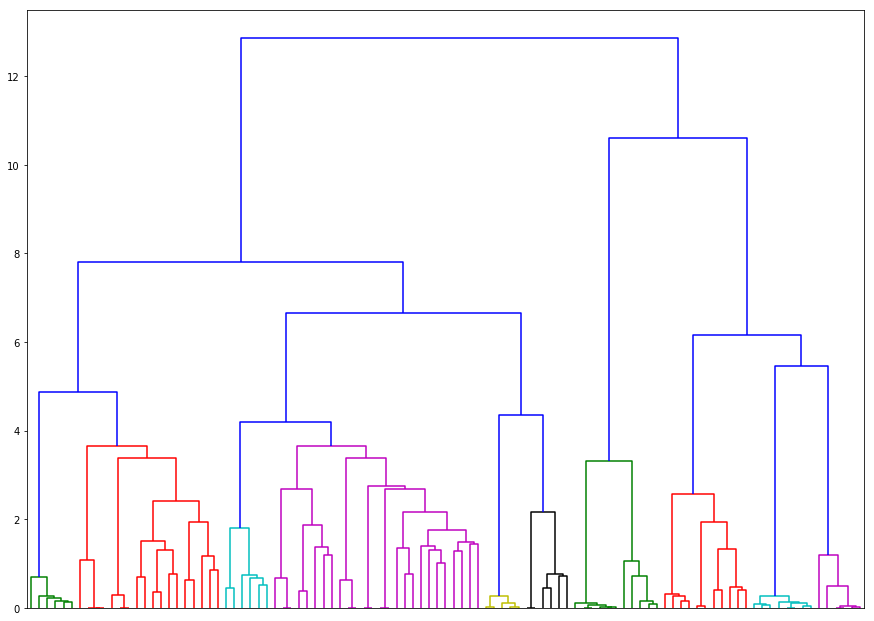

In [51]:
vect = TfidfVectorizer(min_df=1)
tfidf = vect.fit_transform(SS)
SS_sim_mat = (tfidf * tfidf.T).A
linkage_matrix = ward(SS_sim_mat)

plt.figure(figsize=(15, 11))  
dd = dendrogram(linkage_matrix,  
            orientation='top',
            distance_sort='descending',
            show_leaf_counts=True,
            no_labels=True,
            color_threshold=4) # you can tune this value to deside how many group
plt.show() 

## How many group?

In [31]:
G = 10

In [35]:
cluster = AgglomerativeClustering(n_clusters=G, affinity='euclidean', linkage='ward')
cluster.fit_predict(SS_sim_mat)

os.mkdir('manual')
for i in range(G):
    os.mkdir(f'manual/G{i}')

for i,file in enumerate(manual_files):
    copyfile(file,'manual/G'+str(cluster.labels_[i])+'/'+file.split('/')[-1])

# create template excel files to start manual work
for i in range(G):
    temp = [f for j,f in enumerate(manual_files) if cluster.labels_[j] == i]
    DL = []
    for f in temp:
        D = []
        if 'ocr' in f:
            D.append(re.findall('/(\d*?)_',f)[0])
            D.append(re.findall('_(.*?)\.pdf',f)[0])
        else:
            D.append(f.split('/')[1])
            D.append(f.split('/')[2])
        D += [np.nan]*17
        D.append('手動處理！！加油！！')
        DL.append(D)
    pd.DataFrame(DL,columns=columns).to_excel(f'manual/G{i}/template_G{i}.xlsx',index=False)